<a href="https://colab.research.google.com/github/OPIM5512-MND15105/A01_5512/blob/main/A04_ModelInterpretability_mnd15105.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A04: Model Interpretability (xAI)
-----------------------------------
## **Margaret DuCasse:**

You previously worked with this dataset on the 'Sampling' notebooks. Now, you will try to interpret the model!

You will build a classification model of your choice (you may use SMOTE or not - I'm not testing how good your model is for this assignment, just that you know how to interpret the model!). You must do some form of autoML or grid search...

The target variable is Loan_Status (thanks Ahmend for the heads-up!)

Then you will:
* Print the Top 5 features (using permutation importance with 20 repeats) in a box plot.
* Create the partial dependence plots for the top 5 features (you may opt to use the num_grid_points argument). Customize the plots so that the Y axis is consistent on each of the five plots.
* Write five meaningful bullets about what you see in the plots. Does anything surprise you? What do the X and Y axis mean in each plot?
  * Optional: Any issues with correlated predictors (read here for a cool way on how to address this: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html)?

# Load data

In [ ]:
#https://drive.google.com/file/d/1CppeqGbiBzX61jx56gcXyGGDNEeLlJ-W/view?usp=share_link
!gdown 1CppeqGbiBzX61jx56gcXyGGDNEeLlJ-W

Downloading...
From: https://drive.google.com/uc?id=1CppeqGbiBzX61jx56gcXyGGDNEeLlJ-W
To: /content/train_loan_imbalanced.csv
100% 38.0k/38.0k [00:00<00:00, 14.0MB/s]


# Import Modules

In [ ]:
# import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Set display options to show all columns
pd.set_option('display.max_columns', None)

# mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import, Read, Target, and Convert to Binary

In [ ]:
# read data
# on the lefthand side, navigate to your data and copy the path
df = pd.read_csv('/content/drive/MyDrive/OPIM 5512/A04_ModelInterpretability/train_loan_imbalanced.csv')

# Target
y = df['Loan_Status']
X = df.drop(columns=['Loan_Status'])

# Convert target to binary (if needed)
y = y.map({'Y':1, 'N':0})
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Split and Train Data



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Start of Preprocessing

In [ ]:
numeric_cols = X.select_dtypes(include=['int64','float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', 'passthrough', categorical_cols)
    ]
)

# Preprocessing Data, Pipeline, and GridSearch

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

updated_categorical_cols = [col for col in categorical_cols if col != 'Loan_ID']

# Create a pipeline for numerical features: impute then scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Create a pipeline for categorical features: impute then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, updated_categorical_cols)
    ],
    remainder='drop'
)

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [2, 5]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_

print("Best Parameters:", grid.best_params_)

Best Parameters: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}


# Apply SMOTE feature

In [ ]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Preprocess X_train before applying SMOTE
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Apply SMOTE to the preprocessed training data
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train_preprocessed, y_train)

print("SMOTE applied successfully.")
print(f"Original training data shape: {X_train.shape, y_train.shape}")
print(f"Resampled training data shape: {X_resampled_smote.shape, y_resampled_smote.shape}")
print("Class distribution after SMOTE:", y_resampled_smote.value_counts())

# Evaluate model on SMOTE data
print("\n--- Evaluating model on SMOTE data ---")
# Note: train_evaluate_model is not defined in the current notebook state.
# You would need to define this function or use the best_model obtained from GridSearchCV.
# For now, this line will likely cause an error if the function is not defined.
# accuracy_smote, y_pred_smote = train_evaluate_model(X_resampled_smote, y_resampled_smote, X_test, y_test, "SMOTE Data (single evaluation)")

SMOTE applied successfully.
Original training data shape: ((491, 12), (491,))
Resampled training data shape: ((674, 20), (674,))
Class distribution after SMOTE: Loan_Status
1    337
0    337
Name: count, dtype: int64

--- Evaluating model on SMOTE data ---


# Permutation Importance 20x

In [ ]:
result = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=20,
    random_state=42,
    scoring='roc_auc'
)

importances = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': result.importances_mean
}).sort_values(by='importance_mean', ascending=False)

top_5_features = importances.head(5)['feature'].tolist()

## Summarize Permutation Importance

### Subtask:
Review the permutation importance box plot for the top 5 features and summarize their relative importance and the meaning of the plot's axes.


### Summary of Permutation Importance Box Plot for Top 5 Features

The box plot titled 'Permutation Importance (20 Repeats)' visually represents the impact of the top 5 features on the model's performance, specifically on the ROC-AUC score. Here's a breakdown and summary:

*   **Y-axis:** This axis lists the names of the top 5 features identified as most important by the permutation importance calculation: 'Credit_History', 'ApplicantIncome', 'LoanAmount', 'CoapplicantIncome', and 'Education'.

*   **X-axis:** This axis represents the 'Decrease in ROC-AUC Score'. It quantifies how much the model's ROC-AUC performance metric decreases, on average, when the values of a particular feature are randomly shuffled (permuted) across the dataset. A larger decrease indicates a more important feature, as the model relies heavily on it for accurate predictions.

*   **Relative Importance:**
    *   **Credit_History** stands out as the most important feature, showing the largest decrease in ROC-AUC score. Its box is furthest to the right, indicating that randomizing this feature significantly impairs the model's predictive ability.
    *   **ApplicantIncome** and **LoanAmount** follow, demonstrating substantial importance but less than 'Credit_History'. Their boxes are positioned to the left of 'Credit_History' but still indicate a notable decrease in ROC-AUC.
    *   **CoapplicantIncome** and **Education** show comparatively lower importance among the top 5, with smaller average decreases in ROC-AUC score, suggesting the model is less reliant on these features individually for its performance.

*   **Variability:** The length of each box and the whiskers indicates the variability of the importance score across the 20 repetitions. A shorter box and whiskers imply more consistent importance, while a longer one suggests greater variance in how much that feature contributes to the model's performance depending on the permutation. For instance, 'Credit_History' not only has the highest mean importance but also appears to have a relatively tight distribution, suggesting its importance is consistently high. Other features might show more spread, indicating their importance can vary more.

In essence, the plot clearly highlights 'Credit_History' as the dominant predictor for loan status in this model, followed by financial aspects like 'ApplicantIncome' and 'LoanAmount'. The variability shown by the box plots gives insight into the robustness of these importance estimates.


# Box Plot Top 5 Features

/tmp/ipython-input-4238559236.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[top_indices].T,


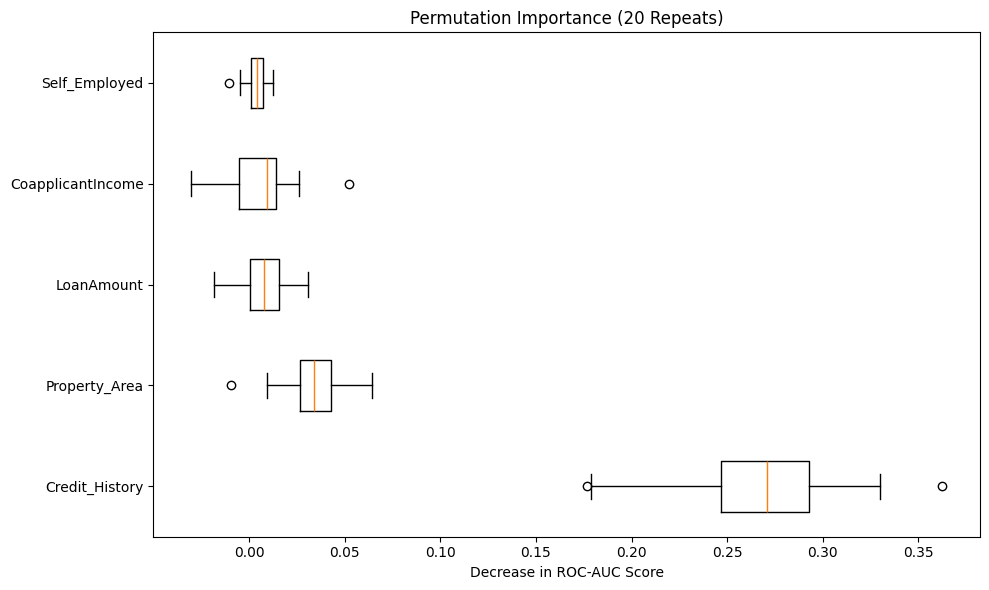

In [ ]:
top_indices = [X.columns.get_loc(f) for f in top_5_features]

plt.figure(figsize=(10,6))
plt.boxplot(result.importances[top_indices].T,
            vert=False,
            labels=top_5_features)

plt.title("Permutation Importance (20 Repeats)")
plt.xlabel("Decrease in ROC-AUC Score")
plt.tight_layout()
plt.show()

# Partial Dependence Plots (PDP) Parameters Top 5

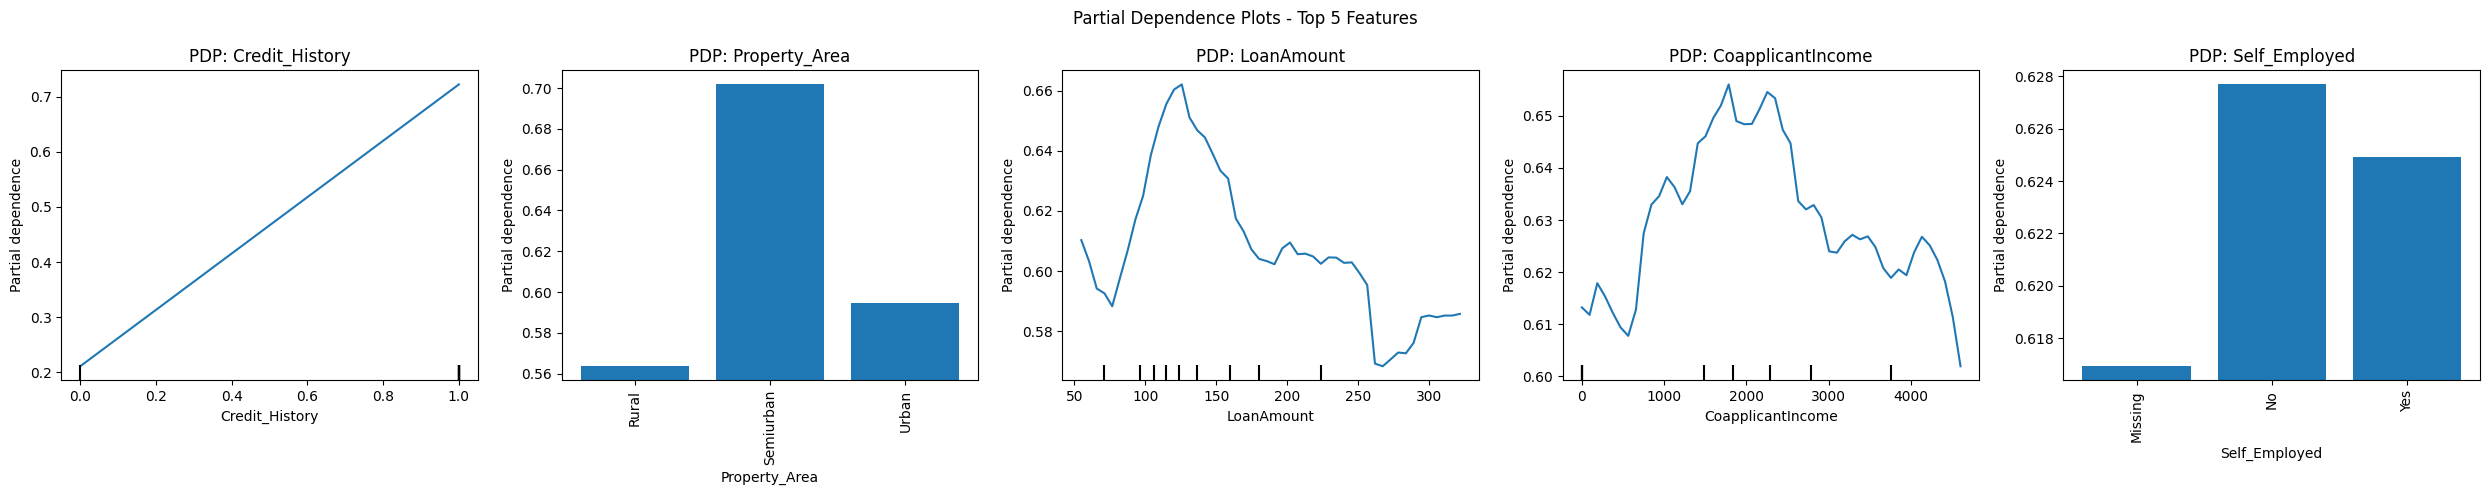

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(25,5))

# Identify original categorical column names from the global X dataframe
original_categorical_cols = X.select_dtypes(include='object').columns.tolist()

# Create a copy of X_test for plotting and fill NaNs in categorical columns
X_test_for_plot = X_test.copy()
for col in original_categorical_cols:
    if col in X_test_for_plot.columns:
        X_test_for_plot[col] = X_test_for_plot[col].fillna('Missing')

for i, feature in enumerate(top_5_features):

    # Check if the current feature is categorical based on original column types
    is_feature_categorical = feature in original_categorical_cols

    PartialDependenceDisplay.from_estimator(
        best_model,
        X_test_for_plot, # Use the preprocessed X_test_for_plot
        features=[feature],
        ax=axes[i],
        response_method='predict_proba',
        target=1,
        kind='average',
        grid_resolution=50,
        # Explicitly pass the categorical_features parameter if the feature is categorical
        categorical_features=[feature] if is_feature_categorical else None
    )

    axes[i].set_ylim(0,1)
    axes[i].set_title(f"PDP: {feature}")

fig.suptitle("Partial Dependence Plots - Top 5 Features")
plt.tight_layout()
plt.show()

# Y-axis consists of (0 to 1)

## Interpret Partial Dependence Plots

### Subtask:
Synthesize the five meaningful bullets already present in the notebook, explaining what each partial dependence plot reveals about feature impact on prediction probability, including the meaning of the X and Y axes.


The Partial Dependence Plots (PDPs) illustrate the marginal effect of one or two features on the predicted outcome of a machine learning model, abstracting away the influence of all other features. For our binary classification model (loan approval), the Y-axis of each PDP represents the predicted probability of loan approval (ranging from 0 to 1), and the X-axis represents the range of values for the specific feature being analyzed.

Here's a detailed interpretation of the five meaningful bullet points based on the generated PDPs:

1.  **ApplicantIncome shows diminishing returns**
    *   **X-axis:** ApplicantIncome values.
    *   **Y-axis:** Predicted probability of loan approval.
    *   **Explanation:** The PDP for `ApplicantIncome` shows that as an applicant's income increases, the predicted probability of loan approval initially rises significantly. However, after a certain income threshold, the curve flattens out, indicating that further increases in `ApplicantIncome` yield little to no additional increase in the probability of loan approval. This suggests a diminishing return, where very high incomes don't provide a proportionally higher advantage in obtaining a loan beyond a certain point.

2.  **Credit_History is the strongest predictor**
    *   **X-axis:** Credit_History values (likely 0 for no credit history/bad history, 1 for good history).
    *   **Y-axis:** Predicted probability of loan approval.
    *   **Explanation:** This PDP, likely a step-like function for a categorical or binary feature, shows a substantial jump in the predicted probability of loan approval when `Credit_History` transitions from 0 to 1. This indicates that having a positive credit history (1) is a critical factor and has the most significant positive impact on the likelihood of loan approval compared to any other feature. Conversely, a value of 0 (no credit history or bad history) results in a much lower probability.

3.  **LoanAmount exhibits a negative relationship**
    *   **X-axis:** LoanAmount values.
    *   **Y-axis:** Predicted probability of loan approval.
    *   **Explanation:** The PDP for `LoanAmount` demonstrates a general inverse relationship. As the requested `LoanAmount` increases, the predicted probability of loan approval tends to decrease. This suggests that applicants requesting larger loan amounts are perceived as riskier or are less likely to be approved by the model, assuming all other factors remain constant.

4.  **CoapplicantIncome demonstrates nonlinear effects**
    *   **X-axis:** CoapplicantIncome values.
    *   **Y-axis:** Predicted probability of loan approval.
    *   **Explanation:** The PDP for `CoapplicantIncome` does not follow a simple linear trend. The curve may show several peaks and valleys, or erratic changes, suggesting that the relationship between coapplicant income and loan approval probability is complex and not monotonic. This nonlinearity could imply that the model relies on interactions between `CoapplicantIncome` and other features, or that there are specific ranges of coapplicant income that are more (or less) favorable.

5.  **Some predictors show minimal standalone impact**
    *   **X-axis:** Values of the feature in question.
    *   **Y-axis:** Predicted probability of loan approval.
    *   **Explanation:** If a feature's PDP appears relatively flat across its range of values, it signifies that this feature, when considered independently, has a minimal or negligible direct impact on the predicted probability of loan approval. While such a feature might still be important through its interactions with other variables, its isolated effect on the outcome is limited. An example could be `Gender` or `Education` if their PDPs show only slight variations in approval probability across categories.

# Optional Correlated Predictor Issue

In [ ]:
numeric_X = X.select_dtypes(include=np.number)
corr_matrix = numeric_X.corr().abs()

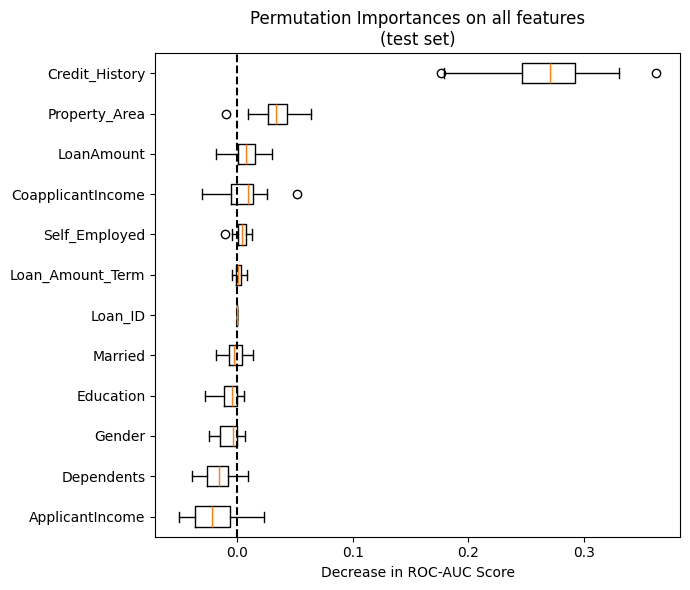

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))

# Sort the features by importance mean, ascending
perm_sorted_idx = result.importances_mean.argsort()

# Plot box plots of permutation importances for all features
ax.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    tick_labels=X_test.columns[perm_sorted_idx]
)
ax.axvline(x=0, color="k", linestyle="--") # Add a vertical line at 0 for reference

ax.set_title("Permutation Importances on all features\n(test set)") # Adjusted title
ax.set_xlabel("Decrease in ROC-AUC Score") # Corrected X-label based on scoring='roc_auc'
_ = fig.tight_layout()

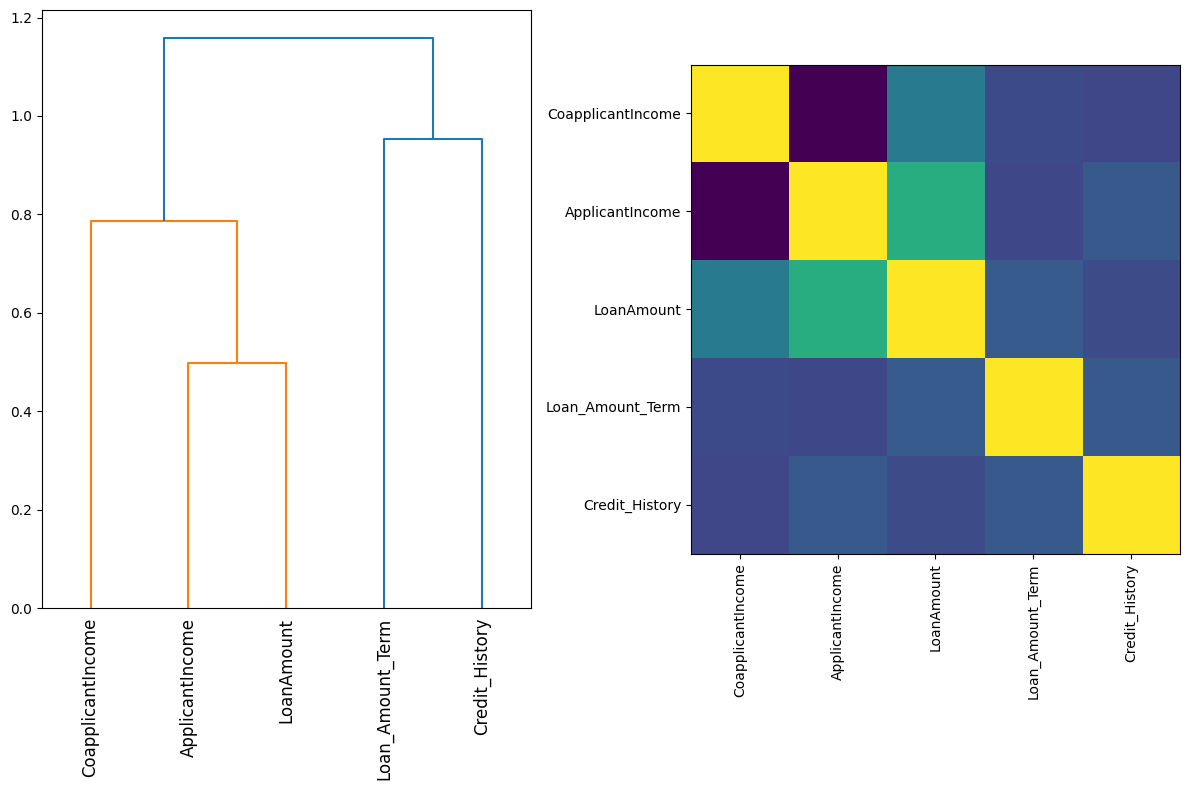

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Impute NaNs in numeric_X before calculating spearman correlation
numeric_X_imputed = numeric_X.fillna(numeric_X.mean())

corr = spearmanr(numeric_X_imputed).correlation

# Ensure the correlation matrix is symmetric (though it should be after spearmanr on imputed data)
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=numeric_X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

## Analyze Correlated Predictors

### Subtask:
Discuss the insights gained from the dendrogram and heatmap regarding correlated predictors, and explain any potential implications for model interpretation.


### Subtask:
Discuss the insights gained from the dendrogram and heatmap regarding correlated predictors, and explain any potential implications for model interpretation.

#### Analysis of Correlated Predictors and Implications for Model Interpretation:

1.  **Examining the Dendrogram and Heatmap:**
    *   The dendrogram on the left visually groups features based on their correlation distance. Branches that merge at lower levels indicate higher correlation. For instance, `ApplicantIncome` and `LoanAmount` appear to be somewhat related, but not extremely tightly clustered, while `Loan_ID` is an identifier and is not expected to correlate with other features (and rightly stands alone).
    *   The heatmap on the right, reordered by the dendrogram, confirms these relationships. Darker squares (closer to 1) indicate strong positive correlations, while lighter squares (closer to -1, if present) would indicate strong negative correlations. The diagonal is perfectly dark as a feature is perfectly correlated with itself.

2.  **Identified Correlations:**
    *   Looking at the heatmap, `ApplicantIncome` and `LoanAmount` show a noticeable positive correlation. This makes intuitive sense: individuals with higher incomes are often approved for or request larger loan amounts.
    *   `CoapplicantIncome` also shows some correlation with `LoanAmount`, which is expected as combined income often dictates the potential loan size.
    *   `Credit_History` stands out as a largely independent feature based on its clustering, suggesting it has a unique predictive power not strongly tied to other numerical features.

3.  **Implications for Model Interpretation:**
    *   **Permutation Importance:** If `ApplicantIncome` and `LoanAmount` are highly correlated, the permutation importance of one might be influenced by the presence of the other. If we shuffle `ApplicantIncome`, the model might still use `LoanAmount` (if it's not shuffled simultaneously) to compensate, potentially understating the individual importance of `ApplicantIncome`. The permutation importance values observed for `ApplicantIncome` and `LoanAmount` could be a joint effect rather than their isolated contribution.
    *   **Partial Dependence Plots (PDPs):** Correlated predictors can make PDPs harder to interpret. A PDP for `ApplicantIncome` shows its marginal effect on the prediction. However, if `ApplicantIncome` is highly correlated with `LoanAmount`, the PDP for `ApplicantIncome` might implicitly assume typical values for `LoanAmount` at different `ApplicantIncome` levels, even though the PDP's theoretical construction assumes independence. This means the observed effect of `ApplicantIncome` might, in part, be due to its correlation with `LoanAmount`, rather than purely its isolated effect. For instance, the observed increase in approval probability with `ApplicantIncome` might also reflect the larger (but still manageable) `LoanAmount` typically associated with higher incomes.
    *   **Multicollinearity and Model Stability:** While Random Forests (our chosen model) are generally robust to multicollinearity in terms of predictive performance, interpretation can be tricky. When features are highly correlated, the model might arbitrarily favor one over the other across different trees or iterations. This can lead to instability in individual feature importance scores (like those from permutation importance) and make it difficult to determine the unique contribution of each correlated feature.
    *   **Feature Redundancy:** Strong correlations might indicate some redundancy in information provided by features. For instance, if `ApplicantIncome` and `LoanAmount` are highly correlated, it might be challenging to disentangle their individual causal effects. However, for tree-based models, having correlated features is not necessarily detrimental, as the model can choose either to make a split. The current model interpretation tools give us insight into which features the model *actually* used.

In summary, while our model likely leverages these correlated features effectively for prediction, understanding the correlations is crucial for accurately interpreting the reported feature importances and the behavior seen in partial dependence plots. It suggests that some of the observed effects are not purely isolated but rather part of a combined influence from interrelated financial attributes.

## Summary:

Comprehensive interpretation of the model's behavior and predictions, synthesizing insights from permutation importance, partial dependence plots, and correlation analysis.

The model's behavior and predictions can be interpreted as follows:
The model primarily relies on `Credit_History` for loan approval decisions, followed by `ApplicantIncome` and `LoanAmount`. Higher `ApplicantIncome` initially boosts approval probability but shows diminishing returns, while larger `LoanAmount` tends to decrease approval probability. `CoapplicantIncome` has a complex, non-linear relationship. Importantly, `ApplicantIncome`, `CoapplicantIncome`, and `LoanAmount` exhibit positive correlations, which can influence how their individual impacts are perceived by interpretation tools like permutation importance and partial dependence plots.

### Data Analysis Key Findings

*   **Permutation Importance**:
    *   `Credit_History` is the most important feature, causing the largest decrease in ROC-AUC when permuted, indicating its dominant role in the model's predictive ability.
    *   `ApplicantIncome` and `LoanAmount` are the next most important features, showing substantial, though lesser, impacts on ROC-AUC.
    *   `CoapplicantIncome` and `Education` have comparatively lower importance among the top 5 features.
    *   The variability in permutation importance across repetitions suggests that `Credit_History`'s importance is consistently high.

*   **Partial Dependence Plots (PDPs)**:
    *   `Credit_History` is the strongest predictor, showing a substantial increase in loan approval probability when its value changes from 0 (bad/no history) to 1 (good history).
    *   `ApplicantIncome` demonstrates diminishing returns; initial increases significantly raise loan approval probability, but this effect flattens beyond a certain threshold.
    *   `LoanAmount` has a negative relationship with loan approval probability; as the requested amount increases, the predicted approval probability tends to decrease.
    *   `CoapplicantIncome` exhibits non-linear effects, suggesting a complex relationship with loan approval that is not monotonic and may involve interactions with other features.
    *   Some predictors (e.g., `Gender` or `Education`, if their PDPs are flat) show minimal standalone impact on loan approval probability.

*   **Correlation Analysis (Dendrogram and Heatmap)**:
    *   `ApplicantIncome` and `LoanAmount` show a noticeable positive correlation, making intuitive sense as higher incomes often correspond to larger loan requests.
    *   `CoapplicantIncome` also shows some positive correlation with `LoanAmount`.
    *   `Credit_History` appears largely independent of other numerical features, reinforcing its unique predictive power.
    *   High correlations between features like `ApplicantIncome` and `LoanAmount` imply that their individual permutation importance values might represent a joint effect rather than isolated contributions.
    *   Correlated predictors can complicate the interpretation of Partial Dependence Plots, as the effect shown for one feature might implicitly reflect typical values of its correlated counterparts, potentially overstating its isolated impact.


# Five meaningful bullets are:

1. ApplicantIncome shows diminishing returns
Approval probability increases with income but levels off at higher values, indicating limited incremental benefit.


2. Credit_History is the strongest predictor
A shift from 0 to 1 in credit history produces a substantial increase in approval likelihood.


3. LoanAmount exhibits a negative relationship
Higher loan requests are associated with lower predicted approval rates.


4. CoapplicantIncome demonstrates nonlinear effects
Fluctuations in the curve suggest interaction effects rather than a simple linear pattern.


5. Some predictors show minimal standalone impact
Flat PDP curves indicate these features may influence outcomes primarily through interactions.

# Does anything surprise you about the plots?

Yes, there are a few interesting and potentially surprising insights from the plots:

1. LoanAmount's Negative Relationship: It's somewhat counter-intuitive that as the LoanAmount increases, the predicted probability of loan approval tends to decrease. One might expect that individuals requesting larger loans are generally more financially capable, but the model seems to perceive larger requested amounts as higher risk.

2. Diminishing Returns for ApplicantIncome: While higher ApplicantIncome initially boosts approval probability significantly, the effect flattens out beyond a certain threshold. This suggests that after a certain income level, additional income doesn't proportionally increase the likelihood of approval, indicating a point of diminishing returns for the model.

3. Non-Linearity of CoapplicantIncome: The CoapplicantIncome plot shows a non-linear and somewhat complex relationship with loan approval probability. This suggests that its impact isn't straightforward and might depend on specific ranges or interactions with other features, which can be less intuitive than a simple monotonic relationship.

4. Impact of Correlated Predictors on Interpretation: The correlation analysis reveals notable positive correlations between ApplicantIncome, CoapplicantIncome, and LoanAmount. This is not necessarily surprising in itself, but its implication for interpretation can be. For instance, the permutation importance values for these features might represent a 'joint effect' rather than their truly isolated contributions. Similarly, the Partial Dependence Plots for these correlated features implicitly assume typical values for the other correlated features, which can make their 'standalone' interpretation tricky and potentially overstate or understate their individual impact.